# Proyecto Final - Text Mining 2021
Garagiola Nazareno


### Pipeline:
---
Detectar words de sentimiento + y - en cada cluster, luego usar estas palabaras para predecir (como una lsita de palabras y tambien a KNN). Usar pysentimiento para poder detectar en cada cluster que palabras predominan con respecto a que sentimiento, revisar si coinciden con las demas clusters
- tweets --▶ CountVectorizer --▶ KMeans (o LDA) --▶ PMI --▶ KNN (este va a ser que predice) o patrones
- tweets --▶      fasttext            --▶ LDA --▶ PMI --▶ KNN (este va a ser que predice) o patrones
---

## Getting started

In [ ]:
!python -m spacy download es_core_news_md
!pip install --upgrade pandas
!pip install pyLDAvis
!pip install pysentimiento

In [3]:
import spacy
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import random

random.seed(10)
np.random.seed(10)

In [ ]:
from gensim.models import KeyedVectors

f = f"drive/MyDrive/tm_series/fasttext_spanish_twitter_100d.vec"

wordvectors = KeyedVectors.load_word2vec_format(f)

In [ ]:
with open('corpus.txt', 'r') as f:
    text = f.read()
    text = text.split('\n')
    corpus = list(set(text))
len(corpus)

19717

In [9]:
with open('stopwords.txt','r') as f:
    es_stop = f.read().split('\n')

## Procesamiento

In [ ]:
import spacy
from pysentimiento import create_analyzer
nlp = spacy.load("es_core_news_md")
analyzer = create_analyzer(task='sentiment',lang="es")

In [ ]:
words = list()
for tw in corpus:
    for w in tw.split(' '):
        words.append(w.lower())

counter = Counter(words)

In [ ]:
def filter_token(token):
    return len(token.text) < 2 or token.is_punct or token.like_url or token.is_space or token.text[0]=='@'

def convert_listwords(list_words):
    text = ""
    for word in list_words:
        text = text + " " + word
    return text

def clean_tweets(corpus=corpus):
    """
    Funcion para filtrar las palabras de los tweets luego de procesarlas con 
    Spacy, y con pysentimento.
    Devuelve dos diccionarios que le asignan el mismo ID a cada tweet.
    """
    data = {}
    wv_data = {}
    for position, tweet in enumerate(corpus):
        doc = nlp(tweet.strip())
        list_words = []
        vector_value = np.array([0 for i in range(100)], dtype=np.float64)
        sentiment = analyzer.predict(tweet)
        for token in doc:
            if filter_token(token): continue
            list_words.append(token.text.lower())
            if not (token.text.lower() in wordvectors.vocab): continue
            vector_value += np.array(wordvectors.word_vec(token.text.lower()), dtype=np.float64)
        
        data[position] = {"tweet": convert_listwords(list_words), "vector": '', "wv_vector": vector_value, "sentiment": sentiment.output}
        #wv_data[position] = {"tweet": convert_listwords(list_words), "vector": vector_value, "sentiment" : sentiment}

    return data #, wv_data

In [7]:
data = clean_tweets(corpus)
tweets = [data[i]['tweet'] for i in data]
sents = [data[i]['sentiment'] for i in data]
wv_vectors = [data[i]['wv_vector'] for i in data]
wv_X = np.matrix(wv_vectors)

In [ ]:
len(data)

---

In [ ]:
#Se puede directamente cargar si ya lo tenias hecho!
with open('drive/MyDrive/tm_series/data.pkl', 'rb') as f:
    data = pickle.load(f)

---
## Algoritmos

Para el proyecto utilizo los siguientes algoritmos y correspondientes implementaciones:

1. [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)
1. [VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html)
1. [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
1. [T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
1. [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

def vectorize(array, min_df):
    vectorizer = CountVectorizer(ngram_range=(1,1), stop_words=es_stop, min_df=min_df)
    matrix = vectorizer.fit_transform(array)
    return matrix

from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold

VARIANCE_THRESHOLD = 1e-7
def transform(matrix):
    selector = VarianceThreshold(threshold=VARIANCE_THRESHOLD)
    normed_matrix = normalize(matrix, axis=1, norm='l1')
    reduced_matrix = selector.fit_transform(normed_matrix)
    return normed_matrix, reduced_matrix

In [10]:
#clean_X_10 = vectorize(tweets, 10)
#clean_X_20 = vectorize(tweets, 20)
#clean_X_30 = vectorize(tweets, 30)
#clean_X_40 = vectorize(tweets, 40)

clean_X = vectorize(tweets, 50)
normed_X, transformed_X = transform(clean_X)

In [11]:
for pos, key in enumerate(list(data.keys())):
    data[key]['vector'] = transformed_X[pos]

In [12]:
transformed_X.shape, wv_X.shape

((19717, 376), (19717, 100))

---

In [13]:
data_file = open("drive/MyDrive/tm_series/data.pkl", "wb")
pickle.dump(data, data_file)

---

In [ ]:
from sklearn.cluster import KMeans

def sklearn_clustering(k, matrix):
    """
    Se usa la euclidea porque ya estan normalizados, y cosine normalizada 
    es parecida a euclidea.
    Retorna los labels de cada punto y una lista con las coordenadas de los 
    centroides de cada cluster.
    """
    clusterer = KMeans(n_clusters=k, random_state=10, n_init=20)
    clusterer.fit(X=matrix)
    return clusterer.labels_, clusterer.cluster_centers_

from sklearn.manifold import TSNE

def tsne_reduction(matrix):
    """
    Reduccion de dimensionalidad via T-sne para poder visualizar los datos
    """
    tsne = TSNE(n_components=2, random_state=10)
    tsne_data = tsne.fit_transform(matrix)
    return tsne_data

In [ ]:
NUM_CLUSTERS = 20

clean_sk_cluster, centers =  sklearn_clustering(NUM_CLUSTERS, transformed_X)
clean_tsne_data = tsne_reduction(transformed_X)

row = [(clean_tsne_data[i], clean_sk_cluster[i], tweets[i], sents[i]) for i in range(len(data))]
all_df = pd.DataFrame(
    data=[(coords[0], coords[1], cluster, word, sent) for coords, cluster, word, sent in row],
    columns=["dim1", "dim2", "cluster", "tweet", "sentiment"]
)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
def plot_all(df, colorbar=False):
    plt.figure(figsize=(22, 8))
    g = plt.scatter(x=df['dim1'],y=df['dim2'], s=10, c=df['cluster'], cmap='tab20', alpha=1)
    if colorbar: plt.colorbar(g)
    plt.show()

def show_cluster(df, n):
    msgs = list(df[df['cluster']==n]['tweet'])
    for msg in msgs:
        text = msg
        print(text)

def df_of_cluster(df, n):
    return df[df['cluster']==n]

from random import randint

def show_sample(df):
    for i in range(NUM_CLUSTERS):
        u = randint(0,NUM_CLUSTERS)
        msg = list(df[df['cluster']==i]['tweet'])[u]
        print(f"Cluster {i}. Sample: {msg}")

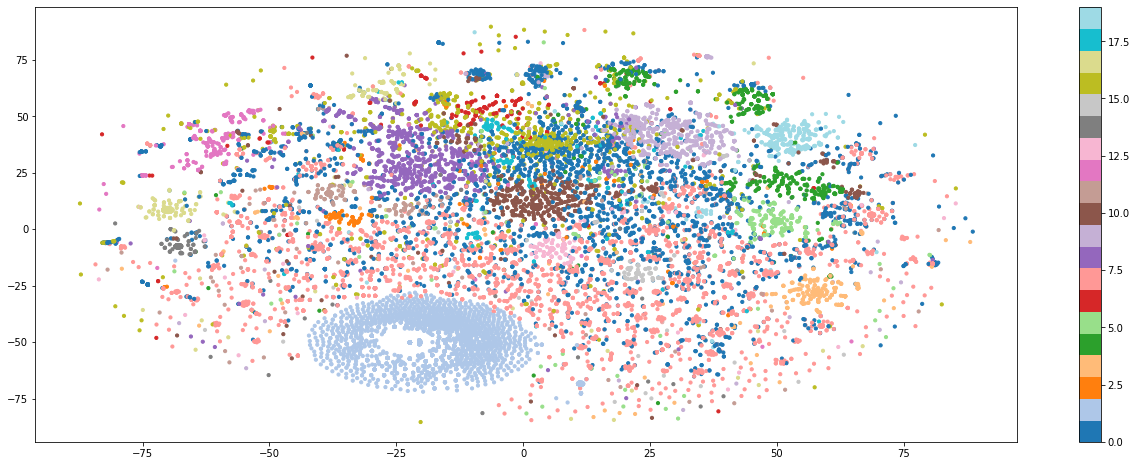

In [ ]:
plot_all(all_df, True)

In [ ]:
show_sample(all_df)

Cluster 0. Sample:  anoche sone que estaba en una especie de juego del calamar con mi familia la primera prueba era comer mierda la pasaba porque tenia un chicle en la boca
Cluster 1. Sample:  anriuten del juego del calamar
Cluster 2. Sample:  del juego del calamar de la vida real medico de trasplantes de renombre mundial dice que los cirujanos chinos deberian ser prohibidos el profesor russell strong esta preocupado por la extraccion de organos humanos en beijing
Cluster 3. Sample:  creo la muneca del juego del calamar creo
Cluster 4. Sample:  internacional cinco personas fueron asesinadas durante un tiroteo en un local en la ciudad de panama mientras celebraban una fiesta de halloween con la tematica de el juego del calamar
Cluster 5. Sample:  vete la mierda como no haz visto el juego del calamar ponte un pijama verla
Cluster 6. Sample:  alguna fiesta en puerta eljuegodelcalamar puede ser la opcion musical
Cluster 7. Sample:  me llama la atencion el juego del calamar
Cluster 8. Sampl

In [ ]:
show_cluster(all_df, 7)

---

In [ ]:
# Ver de tomar centroides y luego hacer los neighbor...
def export_cluster(df, k):
    new_df = df_of_cluster(df, k)
    new_df.to_pickle(f"drive/MyDrive/tm_series/clusters/allcorpus_{k}.pkl")

In [ ]:
#data_file = open("drive/MyDrive/tm_series/data.pkl", "wb")
#pickle.dump(data, data_file)
#with open('drive/MyDrive/tm_series/data.pkl', 'rb') as handle:
#    data = pickle.load(handle)

In [ ]:
#guardamos el df
all_df.to_pickle(f"drive/MyDrive/tm_series/dataframe.pkl")

In [ ]:
#tomamos el df guardado
with open('drive/MyDrive/tm_series/dataframe.pkl', 'rb') as handle:
    all_df = pickle.load(handle)

In [ ]:
all_df.head(5)

,dim1,dim2,cluster,tweet,sentiment
0,4.754383,38.169483,16,,NEU
1,20.502913,-33.966717,7,mi mama empezo ver el juego del calamar me hi...,POS
2,-57.820751,20.901503,0,un joven venezolano obtiene mil dolares al ga...,NEU
3,7.338830,36.588131,0,como padre de dos hijos que ha salido dos dia...,NEU
4,-70.992538,-21.270632,16,ojo que esta nota de sobre la fama tardia del...,NEG


---
## PMI

In [ ]:
def count_words(df):
    words = list()
    for tw in df['tweet'].tolist():
        for w in tw.split(' '):
            if w in es_stop: continue
            words.append(w.lower())

    counter = Counter(words)
    return counter

def pmi_for_sentiment(counter, sent_counter):
    pmi = {}
    for w in sent_counter:
        pmi[w] = np.log(sent_counter[w]/(counter[w]*sent_counter[w]))
        #pmi[w] = np.log(sent_counter[w]/(counter[w]*len(sent_counter)))
    return pmi

MIN = 10
def min_freq(counter):
    copy = Counter(counter)
    for w in counter:
        if copy[w] <= MIN: del copy[w]
    return copy

In [ ]:
#selecccionar cluster a usar
df = df_of_cluster(all_df, 7)

#tomo los subclusters con cada sentimiento
pos = df[df['sentiment'] == 'POS']
neu = df[df['sentiment'] == 'NEU']
neg = df[df['sentiment'] == 'NEG']

#Cuento la frecuencia de cada palabra en el cluster
counter_pos = count_words(pos)
counter_neg = count_words(neg)
counter_neu = count_words(neu)
counter_all = count_words(df)

#Aca podria desechamos todas aquellas palabras que aparezcan menos de MIN veces
counter_pos = min_freq(counter_pos)
counter_neg = min_freq(counter_neg)
counter_neu = min_freq(counter_neu)
counter_all = min_freq(counter_all)


In [ ]:
pos_pmi = Counter(pmi_for_sentiment(counter_all, counter_pos))
neg_pmi = Counter(pmi_for_sentiment(counter_all, counter_neg))
neu_pmi = Counter(pmi_for_sentiment(counter_all, counter_neu))

In [ ]:
pos_pmi.most_common(10)

[('buena', -3.4011973816621555),
 ('gracias', -3.4965075614664802),
 ('bien', -4.110873864173311),
 ('bueno', -4.23410650459726),
 ('vi', -4.836281906951478),
 ('calamar', -8.550241045462437),
 ('juego', -8.577723691156269)]

In [ ]:
neg_pmi.most_common(10)

[('pendejos', -2.3978952727983707),
 ('panico', -2.4849066497880004),
 ('hackeos', -2.4849066497880004),
 ('acceder', -2.4849066497880004),
 ('tanta', -2.5649493574615367),
 ('oido', -2.5649493574615367),
 ('victimas', -2.5649493574615367),
 ('llorando', -2.639057329615259),
 ('cringe', -2.639057329615259),
 ('puta', -2.639057329615259)]

In [ ]:
neu_pmi.most_common(10)

[('simple', -2.3978952727983707),
 ('lebron', -2.3978952727983707),
 ('advierte', -2.4849066497880004),
 ('acuerdo', -2.4849066497880004),
 ('reparte', -2.4849066497880004),
 ('themusicvideo', -2.5649493574615367),
 ('peligro', -2.5649493574615367),
 ('efectos', -2.5649493574615367),
 ('thalia', -2.639057329615259),
 ('anuncio', -2.639057329615259)]

La idea, es que con este PMI, tengo que palabras indican mayor POS o NEG o NEU en cada cluster. Estas palabras pueden formar una lista, si cada palabra contiene una de estas, es indicacion de que es POS o NEG.

---
## LDA

In [ ]:
import gensim
import spacy
nlp = spacy.load("es_core_news_md")

In [ ]:
tw_list = df['tweet'].tolist()

tws = list()
for tw in tw_list:
    words = []
    for w in tw.strip().split(' '):
        if w in es_stop: continue
        words.append(w)
    tws.append(words)

In [ ]:
tws

In [ ]:
dictionary = gensim.corpora.Dictionary(tws)
dictionary.filter_extremes(no_below=10, no_above=0.5)
bow_corpus = [dictionary.doc2bow(doc) for doc in tws]

In [ ]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 7,
                                   id2word = dictionary,                                    
                                   passes = 40,
                                   workers = 4)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [ ]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.185385 -0.152083       1        1  15.026959
2      0.111376 -0.005868       2        1  14.728741
4      0.180187 -0.237534       3        1  14.705754
0     -0.009479  0.058446       4        1  14.419955
5     -0.265112 -0.050672       5        1  14.291877
3      0.215486  0.078577       6        1  13.780238
1     -0.047073  0.309134       7        1  13.046477, topic_info=         Term        Freq       Total Category  logprob  loglift
74    disfraz  145.000000  145.000000  Default  30.0000  30.0000
13     viendo  127.000000  127.000000  Default  29.0000  29.0000
34         vi  121.000000  121.000000  Default  28.0000  28.0000
50      gente  111.000000  111.000000  Default  27.0000  27.0000
9     netflix   94.000000   94.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
153   peligro   12.982211   13.795105   Topic7  -4.5240   1.9759
370     falta   12.981751   13.795087   Topic7  -4.5240   1.9759
76   vestidos   21.770376   28.260453   Topic7  -4.0070   1.7757
64    creador   22.858626   35.429681   Topic7  -3.9583   1.5984
128      sone   18.909988   26.373952   Topic7  -4.1479   1.7040

[268 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
275       2  0.970947           10
17        4  0.928325         2021
214       4  0.960648        acaba
55        3  0.968444        acabo
430       1  0.917464  adolescente
...     ...       ...          ...
200       5  0.984424        viste
435       6  0.926016       volver
16        4  0.941353          wey
129       1  0.992334           xd
400       4  0.911775          you

[266 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 5, 1, 6, 4, 2])

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}")

Topic: 0 
Words: 0.116*"vi" + 0.111*"disfraces" + 0.097*"series" + 0.087*"alla" + 0.078*"final" + 0.068*"personas" + 0.059*"muneca" + 0.054*"casa" + 0.054*"mes" + 0.054*"viendo"
Topic: 1 
Words: 0.155*"disfraz" + 0.084*"bien" + 0.080*"serie" + 0.061*"asi" + 0.054*"juegos" + 0.054*"capitulo" + 0.054*"vida" + 0.054*"dia" + 0.050*"tambien" + 0.050*"veo"
Topic: 2 
Words: 0.216*"visto" + 0.174*"netflix" + 0.081*"arcane" + 0.081*"halloween" + 0.067*"gusto" + 0.062*"alguien" + 0.057*"mundo" + 0.048*"jugar" + 0.048*"game" + 0.048*"miedo"


---
## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def sklearn_KNN(X,y):
    classifier = KNeighborsClassifier(n_neighbors=3, p=2) #p=2 ==> euclidean
    classifier.fit(X,y)
    return classifier

In [ ]:
tws = list()
tws_vects = list()
tws_wv_vects = list()
for j in df.index:
    tws.append(data[j]["tweet"])
    tws_vects.append(data[j]["vector"])
    tws_wv_vects.append(data[j]["wv_vector"])

---

In [ ]:
# 30, 100, 660 -> prohibicion disfraces
# 80, 120, 200, 250 -> muertos, tiroteo
# 320, 40, 290,  -> cansado disfraces
for i in range(0, len(tws), 100):
    print(f"{i}: {tws[i]}")

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
idx = np.array([30, 100, 660, 80, 120, 200, 250, 320, 40, 290])
valoration = np.array(['prohibicion_disfraz','prohibicion_disfraz','prohibicion_disfraz',
                       'muertos', 'muertos', 'muertos','muertos',
                       'cansado_disfraz','cansado_disfraz','cansado_disfraz'])
labels = le.fit_transform(valoration)
feats = np.array([tws_vects[i] for i in idx])


In [ ]:
feats.shape

(10, 100)

In [ ]:
from scipy.sparse import csr_matrix
n = len(idx)
test = csr_matrix((n, transformed_X.shape[1]), dtype=np.int64)
for row in range(n):
    test[row] = feats[row]

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=3, p=2)
KNN.fit(feats, labels)

KNeighborsClassifier(n_neighbors=3)

Con estos tweets recopilados, la idea es poder hacer KNN con estos tweets como centros.

In [ ]:
tws_vects[0].dtype

dtype('float64')

In [ ]:
prediction = KNN.predict(tws_vects[615].reshape(1,-1))
tws[615], le.inverse_transform(prediction)

In [ ]:
for i in range(len(tws)):
    print(f"{tws[i]}: {le.inverse_transform(KNN.predict(tws_vects[i].reshape(1,-1)))}")

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = np.zeros(a_view.shape[:-1], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the r

 podemos reiniciar el mes octubre esq no me hice casi fotos con el disfraz la del juego del calamar en halloween sabes: ['cansado_disfraz']
 squid la criptomoneda inspirada en el juego del calamar alza vuelo halloween: ['muertos']
 la inquietante transformacion de cristina pedroche en la de el juego del calamar todos los disfraces de halloween de zapeando: ['muertos']
 te gusta el juego del calamar te traemos cinco maquillajes inspirados en la serie de moda ideales para dar mucho miedo en la noche de halloween quieres verlos belleza: ['cansado_disfraz']
 ocho muertos entre un tiroteo ejecuciones en una noche de halloween sangrienta en panama cinco personas murieron en una discoteca donde imagenes de el juego del calamar otros tres cadaveres fueron hallados en un vertedero leer: ['cansado_disfraz']
 hice un dub junto unos queridos amigos manana saco por fin mi animacion del juego del calamar fandub dubs halloween videojuegos: ['cansado_disfraz']
 xq en halloween va todo el mundo de demo

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = np.zeros(a_view.shape[:-1], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the r

 me pregunto si este halloween habra alguien que se haya disfrazado de algun personaje de el juego del calamar: ['cansado_disfraz']
 el juego del calamar el disfraz del ano para halloween: ['muertos']
 seguro que ninguno esperabamos que el disfraz mas usado este ano por halloween sea el del juego del calamar: ['cansado_disfraz']
 imperdibles de senora de la harina pan hasta el juego del calamar asi fueron los disfraces de los artistas venezolanos para este halloween 2021 fotos venezuela: ['cansado_disfraz']
 varias escuelas de estados unidos prohibieron los disfraces de el juego del calamar por halloween: ['muertos']
 recuento de cuanta gente me he encontrado disfrazada de el juego del calamar bueno no ha sido para tanto nos vemos el proximo halloween con la siguiente mierda que se ponga de moda: ['cansado_disfraz']
 por halloween se disparan las ventas de uniformes de el juego del calamar en corea del sur: ['muertos']
 increible cinco personas murieron en un tiroteo el viernes durante

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = np.zeros(a_view.shape[:-1], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the r


 halloween ya se acerca halloween seguramente los disfraces mas populares seran los de la serie de netflix el: ['muertos']
 video una fiesta de halloween con tematica de el juego del calamar termino en tragedia luego de que sujetos armadas en el lugar dejando muertos mientras que los cuerpos de otros tres asistentes fueron hallados en el basurero municipal: ['cansado_disfraz']
 el colmo de la locura desatada por esa serie de calamar casi muertos en panama por fiesta tematica de halloween jugando en juego del calamar: ['cansado_disfraz']
 ocho muertos en una fiesta de halloween en la que el juego del calamar: ['muertos']
 en panama hicieron una del juego del calamar por halloween real mataron personas unos unas enfermas: ['muertos']
 al parecer los disfraces que mas este 2021 en halloween es britney el juego del calamar: ['muertos']
 imperdibles de senora de la harina pan hasta el juego del calamar asi fueron los disfraces de los artistas venezolanos para este halloween 2021 fotos vene

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = np.zeros(a_view.shape[:-1], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the r

 imaginense que los chicos este halloween suban un dance practice con tematica del juego del calamar uno salga de la deseos tercermundistas: ['cansado_disfraz']
 yendo ver los trajes de la gente por halloween la mayoria se viste del juego del calamar: ['muertos']
 miles de personas utilizaron sus mejores disfraces para celebrar halloween los atuendos de la serie del juego de calamar los mas utilizados: ['cansado_disfraz']
 escuelas en nueva york prohiben disfraces del el juego del calamar para halloween: ['prohibicion_disfraz']
 aiuda toi en la fiesta de halloween pusieron el remix de el juego del calamar: ['muertos']
 si fui porter tome comi gratis me diverti haciendo de ejecutor del juego del calamar por eso me pagaron halloween: ['cansado_disfraz']
 el disfraz de el juego del calamar el mas buscado en google por los colombianos para halloween: ['muertos']
 cago en todo el puto juego del calamar halloween joder: ['muertos']
 la musica de los juegos del juego del calamar casi tienen e

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = np.zeros(a_view.shape[:-1], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the r

 una fiesta de halloween que la serie el juego del calamar termino en masacre noticia: ['muertos']
 la originalidad que tienen todos los que en halloween se han disfrazado de algo del juego del calamar es taaaaan impresionante en serio los mas creativos del mundo no teneis rival: ['cansado_disfraz']
 jefferson farfan se disfraza como personaje de el juego del calamar en halloween video: ['cansado_disfraz']
 horror en halloween una fiesta de el juego del calamar acaba con ocho muertos en panama via: ['muertos']
 el juego del calamar marca el primer halloween sin restricciones tras la pandemia: ['muertos']
 termine el juego del calamar entretenida pero no la volveria ver definitivamente lanzar una serie koreana con disfraces 1/2 meses antes de halloween no fue ninguna casualidad: ['cansado_disfraz']
 apuesto lo que sea que para halloween la gente va salir disfrazada del juego del calamar: ['cansado_disfraz']
 escuelas del estado de prohibieron los disfraces de el juego del calamar para h

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = np.zeros(a_view.shape[:-1], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the r